In [1]:
#Load data manipulation package
import numpy as np
import pandas as pd

#Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

#Data dumb store
import joblib

# 1. Business Understanding
---

- Knowing customer churn is essential for internet provider company for effectively prevent them using appropriate marketing initiative
- Internet provider company wants to give specific marketing initiative for preventing customer churn
- They want to spend this budget as efficient as possible

## 1.2 Business Questions
---

- How can internet provider company develop marketing effectiveness strategy to increase reduce 30% of churn?
- What marketing initiatives are suitable to reduce the 30% customer churn?
- How to prevent unnecessary budget allocation?

## 1.3 Modelling Task
---

- Output target: **customer status of churn (categorical)**


- The goal of this project is to predict whether a customer will churn or not based on various features.
Task: **Classification task**


- We need a model that can be easily interpreted so that we can understand how each feature contributes to the prediction. This can help us gain insights into the underlying factors that influence whether a customer will churn or not.
Model used: **Logistic regression**


- We will use ROC/AUC as our evaluation metric since we want it's not influeced by imbalance target and we need to measure threshold using ROC/AUC. **Evaluation metric: ROC/AUC & Recall**

# 2. Modelling Workflow
---

## **Machine Learning Workflow** (Simplified)

### 1. <font color='blue'> Importing Data to Python:
    * Data description, Importing data, Data splitting
    
### 2. <font color='blue'> Exploratory Data Analysis:
    *Descriptive statistic, Missing value checking, Data exploration
    
### 3. <font color='blue'> Prepocessing:
    * Missing value handling, Outliers handling

### 4. <font color='blue'> Modelling:
    * Model fitting, Evaluation
    
### 5. <font color='blue'> Lift Chart & Interpretation:
    * Targetting customer churn, Coeficient interpretation

# 3. Load Data
---

- We want to describe our features and target feature
- Load the data from specific path

## 3.1 Data Description
---

The potential **predictors** for the response variable are:
1. `is_tv_subscriber`
 - `is_tv_subscriber = 0` for the customers who didn't subscribe to the TV package or only subscribe to the internet package.
  - `is_tv_subscriber = 1` for the customers who subscribe to the TV package.


2. `is_movie_package_subscriber`
  - `is_movie_package_subscriber = 0` for the customers who didn't subscribe to the movie package or only subscribe to the internet package.
  - `is_movie_package_subscriber = 1` for the customers who subscribe to the movie package.


3. `subscription_age` is the years of customer using the internet service.
4. `bill_avg` is the last three months' bill average.
5. `remaining_contract` is the year remaining for the customer's subscription contract. If null, the customer hasn't had a contract.
6. `service_failure_count` is the number of calls to the Call Center for service failure for the last three months.
7. `download_avg` is the last three months internet usage in GB.
8. `upload_avg` is the last three months upload in GB.
9. `download_over_limit` is the count of the internet usage over the customer's limit.

**Target variable**:
- `churn`
  - `churn = 0` for the customers who retain.
  - `churn = 1` for the customers who cancel their subscription before the contract ends or the customers who didn't renew their subscription after the contract ended.

## 3.2 Importing Data
---

In [2]:
X_train_clean = joblib.load("data/processed/X_train_clean.pkl")
y_train_clean = joblib.load("data/processed/y_train_clean.pkl")
X_valid_clean = joblib.load("data/processed/X_valid_clean.pkl")
y_valid_clean = joblib.load("data/processed/y_valid_clean.pkl")
X_test_clean  = joblib.load("data/processed/X_test_clean.pkl")
y_test_clean  = joblib.load("data/processed/y_test_clean.pkl")

# 4. Modelling
---

## 4.1 Baseline Model
---

- The baseline model is a simple and straightforward model used as a point of reference for comparing the performance of other models.

- By comparing the performance of more advanced models to the baseline model, we can assess whether the other models provide any significant improvement.

- The baseline model helps establish a benchmark to evaluate the performance of more complex models.

- If a more sophisticated model performs worse than the baseline model, it indicates that the advanced model is not effective and needs improvement.


In [3]:
def fit_eval_model(model, x_train, y_train, x_valid, y_valid):
    """
    Fit & evaluate model with AUC as its scoring metrics.

    Parameters
    ----------
    model : sklearn object
        The estimator.

    x_train, x_valid : pandas DataFrame
                       Sample of input train & valid data.

    y_train, y_valid : pandas series
                       Sample of output train & valid data.


    Returns
    -------
    model_summary : pandas dataframe
        Store model performance on train & valid set.
    """
    # Fit the model
    model.fit(x_train, y_train)

    # Predict the class probability for the given train & valid set
    y_train_pred = model.predict_proba(x_train)[:, 1]
    y_valid_pred = model.predict_proba(x_valid)[:, 1]

    # Calculate the performance on train & valid data
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_valid = roc_auc_score(y_valid, y_valid_pred)

    # Summarize the model
    model_summary = pd.DataFrame({'AUC train': [auc_train], 
                                  'AUC valid': [auc_valid]})

    return model_summary

In [4]:
# Import package
from sklearn.dummy import DummyClassifier

In [5]:
# Create dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

In [6]:
# Import package
from sklearn.metrics import roc_auc_score

In [7]:
# Get the model performance
summary_baseline = fit_eval_model(model = dummy_clf,
                                  x_train = X_train_clean,
                                  y_train = y_train_clean,
                                  x_valid = X_valid_clean,
                                  y_valid = y_valid_clean)

In [8]:
# add model name
summary_baseline['Model'] = 'Baseline'

# Rearrange the columns
summary_baseline.columns = ['AUC train', 'AUC valid', 'Model']

# show 
summary_baseline

,AUC train,AUC valid,Model
0,0.5,0.5,Baseline



**Dummy Classifier**

- A dummy classifier is a basic classification model that follows a predefined strategy to make predictions.

- Strategy = "most_frequent": In this case, the dummy classifier's strategy is set to "most_frequent," which means it always predicts the most frequent class from the training data.

- The dummy classifier with the "most_frequent" strategy predicts the majority class for all instances in the dataset, regardless of the input features.

- Metrics like accuracy, precision, recall, and F1 score can be used to compare the performance of other models against the baseline model.

## 4.2 Modelling
---

**Sigmoid Function**
- The sigmoid function is often used in logistic regression because it allows us to map the output of a linear model (which can take on any value) to a probability (which must be between 0 and 1).
<br>
$$
\begin{align*}
p(x) &= \frac{e^{(\beta_{0}+\beta_{1}x)}}{1+e^{(\beta_{0} +\beta_{1}x)}} \\
&= \frac{e^{\text{log(odds)}}}{1+e^{\text{log(odds)}}} \\
\end{align*}
$$
<br>
- When we use logistic regression for classification, we use a threshold value (usually 0.5) to decide whether a given input belongs to the positive class or the negative class.

<br>

**Likelihood Function**

<br>

In general, **likelihood function** for the identical and independent observations with binary response:

$$
\mathcal{L} = \prod_{i=1}^{n}p(x_{i})^{y_{i}}[1-p(x_{i})]^{(1-y_{i})}
$$

<br>

**Maximum Likelihood Estimation**

<br>

- We want the maximum likelihood estimate $p(x)$ from the n observations, where:
$$
p(x) = \frac{e^{(\beta_{0}+\beta_{1}x)}}{1+e^{(\beta_{0}+\beta_{1}x)}}
$$

<br>

- To maximize the likelihood function $\mathcal{L}$, we need to find the optimum parameter $\beta_{0}$ and $\beta_{1}$.

<br>

**Negative Log Likelihood (NLL)**

<br>


- To make it easier to compute, we transform the likelihood function into **log likelihood function**:

<br>

$$
\log(\mathcal{L}(\beta)) = \sum_{i=1}^{n}(y_{i}\log[p(x_{i})]+(1-y_{i})\log[1-p(x_{i})])
$$
<br>
- Our objective is to maximise this function by finding the optimal value of $\beta_{0}$ and $\beta_{1}$

- We want to maximize the log likelihood, but gradient descent optimization works to minimize the cost function.
- Thus, we take the negative value of log likelihood as the cost function.
- So if larger negative value we get basically is the same as we maximise the likelihood function --> Our goal is to minimize the negative log likelihood (NLL) function
- The **negative log likelihood (NLL)** or **log loss** is defined as:
<br>
$$
-\log(\mathcal{L}(\beta)) = -\sum_{i=1}^{n}(y_{i}\log[p(x_{i})]+(1-y_{i})\log[1-p(x_{i})])
$$

<br>

**Gradient Descent**
- Since we want to **Minimize** the cost function negative log likelihood, we can se by this following notation:
<br>

$$
\underset{\beta}{\arg \min} \ \text{NLL}(\beta)
$$

- In order to implement gradient descent, we have to take partial derivative of log-likelihood with respect to each parameter
- The derivative of log loss or negative log-likelihood (NLL) w.r.t. $\beta_{j}$ is called the gradient of $\beta_{j}$.
<br>
<br>
$$
\frac{\partial \text N \text L \text L}{\partial \beta_{j}}=-\sum_{i=1}^{n}\left [ y_{i}-p(x_{i}) \right ]x_{j}
$$ <br>
- Then we keep updating parameter $\beta$ until converge on the best value of $\beta$ (Or until several n_interation) <br>
<br>
$$
\beta_{j}^{new} := \beta_{j}^{old} - \alpha \frac{\partial \text N \text L \text L}{\partial \beta_{j}^{old}}
$$ <br>
- Where $\alpha$ is the learning rate and $:=$ operation overwrite the $\beta_{old}$ with $\beta_{new}$

**Decision Boundary**
- After finding the optimal value of $\beta_{0}$ and $\beta_{1}$, we can set the parameter to the sigmoid function
<br>

$$
p(x) = \frac{e^{(\beta_{0}+\beta_{1}x)}}{1+e^{(\beta_{0}+\beta_{1}x)}}
$$
<br>
- Then we can predict the input x with output as probability with the decision boundary: <br> <br>
\begin{equation}
\text{decision}(x) = \begin{cases}
1 & \text{if } p(y=1|x) > 0.5 \\
0 & \text{otherwise}.
\end{cases}
\end{equation}

Ref: [Lecture Note](https://cs229.stanford.edu/notes2021fall/cs229-notes1.pdf)

In [9]:
# Import package
from sklearn.linear_model import LogisticRegression

In [10]:
# Create modeling object
lr_clf = LogisticRegression(penalty = 'none',
                            class_weight = 'balanced',
                            max_iter = 10000)

In [11]:
# Get the model performance
summary_logreg = fit_eval_model(model = lr_clf,
                                x_train = X_train_clean,
                                y_train = y_train_clean,
                                x_valid = X_valid_clean,
                                y_valid = y_valid_clean)

In [12]:
# add model name
summary_logreg['Model'] = 'Logistic Regression'


# concat baseline with logistic regression
summary_result = pd.concat([summary_baseline, summary_logreg], 
                           ignore_index=True)

# show 
summary_result

,AUC train,AUC valid,Model
0,0.500000,0.50000,Baseline
1,0.916695,0.90628,Logistic Regression


- Our best model is logistic regression model
- We can see by looking at the AUC score in train and valid data

## 4.3 Finding Threshold
---

**FP & FN**

- FP = False Positive, predicted as churn (positive), in fact they're not churner
- FN = False Negative, predicted as not churn (negative), in fact they're churner


**Recall our cost information**

- cost acquisition (cost to acquire new customers) --> \$50 / customer
- cost reactivation (cost to retain existing customers) --> \$15 / customer

**Conclusion**

- if we give reactivation treatment to non-churner (FP), we only lose \$15 per customer
- but if we lose a customer (it means we need to acquire), we'll lose $50. 
- Meaning that it is more risky for people who originally churn but failed to be predicted (or false negative)

**Objective**

- Minimize False Negative

------
- After finding the best model, we need to find the best threshold for our model
- We need to find appropriate threshold based on our model objective --> minimize FN or highest TPR
- Then we need to set which evaluation metrics suitable for the objective
- We choose recall as our objective is minimize False Negative
- We need to minimze False Negative because acquire new customers is way more expensive than retaining customers

In [13]:
from sklearn.metrics import recall_score

In [14]:
def get_best_threshold(x_valid, y_valid, model):
    """
    Function to tune & get the best decision threshold
    
    Parameters
    ----------

    x_valid, y_valid : pandas dataframe
                       valid data (x and y)

    model : object
            fitted model
    
    Returns
    ------
    best_threshold : float
                     best threshold for precision score


    """
    # set threshold candidate
    thresholds = np.linspace(0, 1, 100)

    # Get the prediction probability
    y_pred_proba = model.predict_proba(x_valid)[:, 1]

    # Initialize
    metric_threshold = pd.Series([])

    # Optimize
    for threshold_value in thresholds:
        # Get predictions
        y_pred = (y_pred_proba >= threshold_value).astype(int)

        # Get the precision score
        metric_score = recall_score(y_valid, y_pred, average='macro')

        # Add to metric_score
        metric_threshold[metric_score] = threshold_value

    # Find the threshold @max metric score
    metric_score_max_index = metric_threshold.index.max()
    best_threshold = metric_threshold[metric_score_max_index]
    print('=============================================')
    print('Best threshold :', best_threshold)
    print('Metric score   :', metric_score_max_index)
    print('=============================================')

    # Return threshold
    return best_threshold

In [15]:
best_threshold = get_best_threshold(x_valid = X_valid_clean,
                                    y_valid = y_valid_clean,
                                    model = lr_clf)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2160\1592371366.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metric_threshold = pd.Series([])


Best threshold : 0.5555555555555556
Metric score   : 0.8524215901684709


In [16]:
best_threshold

0.5555555555555556

In [17]:
# Import package
from sklearn.metrics import roc_curve

In [18]:
def plot_roc_curve(y_true, y_score, threshold=None):
    """
    Plot the Receiver Operating Characteristic (ROC) curve for a binary classification model.

    Parameters:
    -----------
    y_true : pandas series
        True binary labels indicating the ground truth.

    y_score : pandas series
        Target scores or predicted probabilities from the model.

    threshold : float or None, optional
        Threshold value for marking a specific point on the ROC curve.
    """

    # Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)

    # Calculate AUC score
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    auc = round(auc, 4)

    # Plot ROC curve
    plt.plot(fpr, tpr, label="AUC Model = " + str(auc))

    if threshold is not None:
        # Find the closest threshold index to the specified threshold value
        threshold_idx = np.abs(thresholds - threshold).argmin()

        # Plot the threshold point on the curve
        plt.scatter(fpr[threshold_idx], tpr[threshold_idx], color='red', marker='o')
        plt.text(fpr[threshold_idx], tpr[threshold_idx]+0.01, f"{threshold:.2f}", fontsize=8, ha='right', va='bottom')

        # Extract TPR and FPR values for the specified threshold
        tpr_value = tpr[threshold_idx]
        fpr_value = fpr[threshold_idx]
        print(f"For Threshold = {threshold:.2f}: TPR = {tpr_value:.4f}, FPR = {fpr_value:.4f}")

    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.legend(loc=4)
    plt.show()

In [19]:
y_valid_prob = lr_clf.predict_proba(X_valid_clean)

For Threshold = 0.56: TPR = 0.8123, FPR = 0.1072


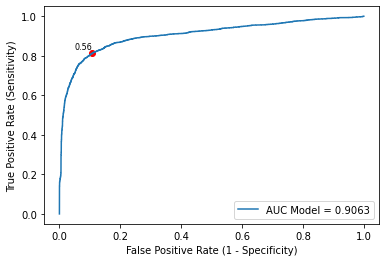

In [20]:
plot_roc_curve(y_true = y_valid_clean,
               y_score = y_valid_prob[0:,1],
               threshold = best_threshold)

In [21]:
# Predict probabilities
y_test_prob = lr_clf.predict_proba(X_test_clean)[:, 1]

# Predict based on the threshold
y_test_pred = (y_test_prob >= best_threshold).astype(int)

# Print Result
print('Testing RESULT:')
print(f'Test Precision Score : {recall_score(y_test_clean, y_test_pred)}')

Testing RESULT:
Test Precision Score : 0.8066620879120879


# 5. Probability Decile Analysis and Gains Chart
---

In [22]:
# print total number of customers
print(f'Number of customers : {X_test_clean.shape[0]}')

Number of customers : 7415


In [23]:
# Import package
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [25]:
def build_lift_data(model, X, y):
    """
    Build a lift curve based on the given model's predictions.

    Parameters
    ----------
    model : object
        The trained model with a `predict_proba` method.

    X : array-like or dataframe, shape (n_samples, n_features)
        The input features.

    y : array-like, shape (n_samples,)
        The true target labels.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the lift curve analysis at decile level.

    """
    # Step 1: Getting the Model Probabilities
    df = pd.concat([X, y], axis=1)
    y_pred_prob = model.predict_proba(X)[:, 1]
    df['pred_prob'] = y_pred_prob

    # Step 2: Create Deciles based on the Model Probabilities
    df['P_Rank'] = pd.qcut(df['pred_prob'].rank(method='first').values, 10, duplicates='drop').codes + 1

    # Step 3: Summarize the data at Decile Level for Analysis
    rank_df = df.groupby('P_Rank')['churn'].agg(['count', 'mean']).sort_values(by='P_Rank', ascending=False)
    rank_df.rename(columns={'mean': 'Actual_event_rate'}, inplace=True)

    # Step 4: Event Capture Analysis across Probability Deciles
    rank_df['N_events'] = rank_df['count'] * rank_df['Actual_event_rate']
    rank_df['cum_events'] = rank_df['N_events'].cumsum()
    rank_df['event_cap'] = rank_df['N_events'] / max(rank_df['N_events'].cumsum())
    rank_df['cum_event_cap'] = rank_df['event_cap'].cumsum()

    # Step 5: Non-Event Capture Analysis across Probability Deciles
    rank_df['N_non_events'] = rank_df['count'] - rank_df['N_events']
    rank_df['cum_non_events'] = rank_df['N_non_events'].cumsum()
    rank_df['non_event_cap'] = rank_df['N_non_events'] / max(rank_df['N_non_events'].cumsum())
    rank_df['cum_non_event_cap'] = rank_df['non_event_cap'].cumsum()

    # Step 6: Compute Lift over Baseline Event Rate
    rank_df['Baseline_Event_Rate'] = (max(rank_df['cum_events']) / max(rank_df['count'].cumsum()))
    rank_df['Lift_over_Avg'] = rank_df['Actual_event_rate'] / rank_df['Baseline_Event_Rate']

    rank_df = rank_df.reset_index()
    rank_df['Decile'] = rank_df.index + 1

    return rank_df

In [26]:
rank_df = build_lift_data(model = rd_search, 
                          X = X_test_clean, 
                          y = y_test_clean)

In [27]:
rank_df

,P_Rank,count,Actual_event_rate,N_events,cum_events,event_cap,cum_event_cap,N_non_events,cum_non_events,non_event_cap,cum_non_event_cap,Baseline_Event_Rate,Lift_over_Avg,Decile
0,10,742,1.000000,742.0,742.0,0.254808,0.254808,0.0,0.0,0.000000,0.000000,0.392717,2.546360,1
1,9,741,0.998650,740.0,1482.0,0.254121,0.508929,1.0,1.0,0.000222,0.000222,0.392717,2.542924,2
2,8,742,0.998652,741.0,2223.0,0.254464,0.763393,1.0,2.0,0.000222,0.000444,0.392717,2.542928,3
3,7,741,0.608637,451.0,2674.0,0.154876,0.918269,290.0,292.0,0.064402,0.064846,0.392717,1.549809,4
4,6,741,0.139001,103.0,2777.0,0.035371,0.953640,638.0,930.0,0.141683,0.206529,0.392717,0.353947,5
5,5,742,0.072776,54.0,2831.0,0.018544,0.972184,688.0,1618.0,0.152787,0.359316,0.392717,0.185315,6
6,4,741,0.059379,44.0,2875.0,0.015110,0.987294,697.0,2315.0,0.154786,0.514102,0.392717,0.151201,7
7,3,742,0.025606,19.0,2894.0,0.006525,0.993819,723.0,3038.0,0.160560,0.674661,0.392717,0.065203,8
8,2,741,0.016194,12.0,2906.0,0.004121,0.997940,729.0,3767.0,0.161892,0.836553,0.392717,0.041237,9
9,1,742,0.008086,6.0,2912.0,0.002060,1.000000,736.0,4503.0,0.163447,1.000000,0.392717,0.020591,10


## 5.1 Decile Distribution
---

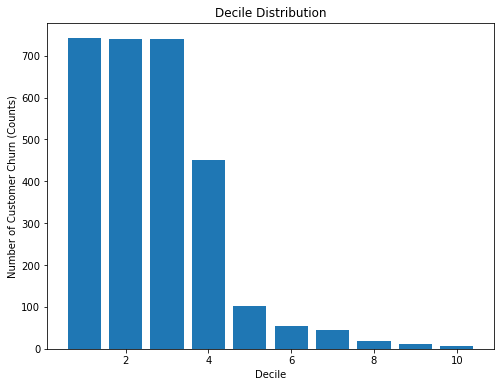

In [28]:
plt.figure(figsize=(8, 6))
plt.bar(rank_df['Decile'], rank_df['N_events'])
plt.xlabel('Decile')
plt.ylabel('Number of Customer Churn (Counts)')
plt.title('Decile Distribution')
plt.show()

- Group decile 1-3 is the top 3 highest number of customer churn
- We probably can implement marketing treatment only on the most "customer churn" group rather than treat all groups 
- Remember, our objectives also prevent unnecessary allocation of resources and efforts

## 5.2 Lift Value
---

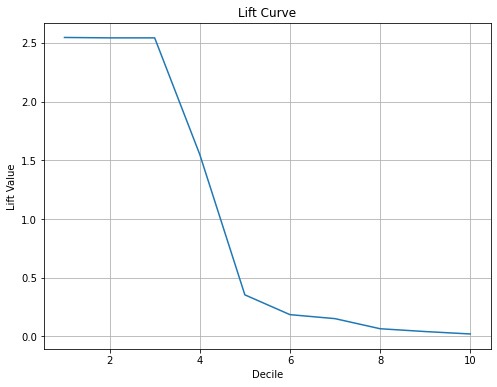

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(rank_df['Decile'], rank_df['Lift_over_Avg'])
plt.grid()
plt.xlabel('Decile')
plt.ylabel('Lift Value')
plt.title('Lift Curve')
plt.show()


- According to the lift value distribution chart, select the groups whose lift value is greater than or equal to 1 as a candidate for promotion to retain them
- Groups 1-4 are suitable for implementing promotions for retention (reducing churn and preventing churn)
- We set group 1-4 as our target and give them marketing treatment to prevent them from churning

## 5.3 Cumulative Churn Rate
---

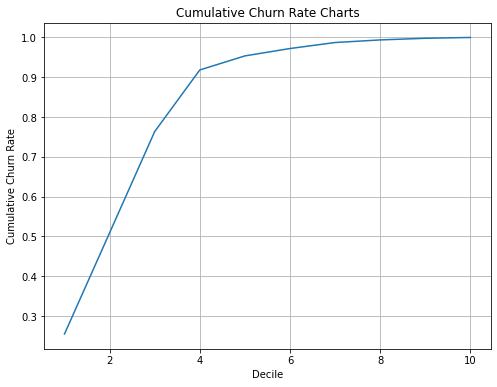

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(rank_df['Decile'], rank_df['cum_event_cap'])
plt.xlabel('Decile')
plt.ylabel('Cumulative Churn Rate')
plt.grid()
plt.title('Cumulative Churn Rate Charts')
plt.show()


- Marketers can save the marketing budget and increase marketing initiative targeting for only target around 80% of cumulative churn ration
- It means, marketers only need to target group 1-4 in order to reduce most churn cases (80% cumulative churn)


# 6. Interpretation & Recommendation
----

- To interpret in terms of odds, we transform the log(odds) into odds.

$$
 \text {log(odds)} = \beta_{0}+\beta_{1}x
$$
  - Thus,
$$
\begin{align*}
\text {odds} &= e^{(\beta_{0}+\beta_{1}x)} \\
&= e^{\beta_{0}} \left (e^{\beta_{1}} \right )^{x} \\
\end{align*}
$$
<br>
  - Interpretation: **the estimated odds of success multiply by $\text{exp}(\beta_{1})$ for one unit increase in $x$.**

## 6.1 Interpretation
---

In [32]:
def get_coeff(best_model):
    """
    Function to extract coefficient
    
    Parameters:
    -----------
    best_model: fitted object model
                The best logistic regression model obtained from randomized cross-validation.
    Return:
    -------
    coef_df: pandas dataframe
             A DataFrame containing the coefficients and intercept.
    """
    # Extract the coefficients
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    # create df
    coef_df = pd.concat([pd.DataFrame(X_train_clean.columns, columns=['Features']), 
                     pd.DataFrame(coefficients.T, columns=['Coeff'])], axis=1)

    coef_df = coef_df.append({"Coeff": intercept[0], "Features": "Intercept"}, ignore_index=True)
    
    coef_df['Odds'] = np.exp(coef_df['Coeff'])
    
    return coef_df

In [33]:
get_coeff(best_model)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2160\2902316735.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coef_df = coef_df.append({"Coeff": intercept[0], "Features": "Intercept"}, ignore_index=True)


,Features,Coeff,Odds
0,is_tv_subscriber,-2.373467,0.093157
1,is_movie_package_subscriber,0.060564,1.062436
2,subscription_age,-0.276886,0.758141
3,bill_avg,-0.008621,0.991416
4,reamining_contract,-2.901357,0.054949
5,service_failure_count,0.178805,1.195788
6,download_avg,-0.011906,0.988165
7,upload_avg,-0.078894,0.924138
8,download_over_limit,0.695248,2.004205
9,Intercept,4.817533,123.659666


## 6.2 Recommendation
---

`Intercept` :

- Estimated odds of a customer will churn when all variable equal to 0 is 4.817533
- In simply term, if we do nothing, the estimated odds for customer churn is a 123.659666

`download_over_limit`
- This variable represents the count of internet usage instances exceeding the customer's limit
- The estimated odds for customer churn is a  2.004205
- **Recommendation**: Help customers manage their internet usage within the limits and prevent bill shocks.
- **Initiative**: Provide usage alerts, offer data management tools, and suggest appropriate data plans based on usage patterns.

`service_failure_count`:
- This variable represents the number of calls to the Call Center for service failure in the last three months. 
- The coefficient value is 0.178805, The estimated odds for customer churn is 1.195788
- **Recommendation**: Improve service quality and address customer service issues promptly.
- **Initiative**: Identify and address common service failure issues, enhance customer support channels, and implement proactive service monitoring and troubleshooting.

## 6.3 **Summary**
---

Given
- marketers only need to target group 1-4 in order to reduce most churn cases (80% cumulative churn)
- Number of customer included in this retention campaign: (approx) 2966
- Cost for retaining each customer \$15

How to prevent unnecessary allocation?

- It means we only need 15*2966 or arround \$44,490 budget to treat these customers (Using recommendation above)
- We save \$5510 to spend in marketing budget


How to reduce 30% churn? we need assumption to answer this
- With assumption **80% effectiveness** of the campaign, we can prevent 2373 customers from churning
- Remeber we have 54% proportion of churn customers, now we have arround 32% customer churn, it means the percentage reduction from 54% to 32% is approximately 40.74%.